# Ensemble Learning

## Initial Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
# Model scoring libs
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [ ]:
# scik-kit and imblearn ML libs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier

In [4]:
# Visualization libs
from sklearn import tree
import pydotplus
from IPython.display import Image

## Read the CSV and Perform Basic Data Cleaning

In [5]:
# Load the data
file_path = Path('resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)                

# Preview the data
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [6]:
df.shape

(68817, 86)

## Data Pre-Processing

In [7]:
# Drop useless columns that have no predictive value. Go through the raw file first and this saves a great deal of time. 
# Any column that has the same value is useless. Check all non-numeric columns for same value across all rows. 

df.drop('pymnt_plan', axis=1, inplace=True )            # this column only has 1 value for every row. value 'n', no applicants are on a pymt plan. Useless column.
df.drop('hardship_flag', axis=1, inplace=True)          # all rows under column have the same value, meaningless.
df.drop('debt_settlement_flag', axis=1, inplace=True)   # all rows have same value. no predictive characteristic. 
df.drop('recoveries', axis=1, inplace=True)             # same value.
df.drop('collection_recovery_fee', axis=1, inplace=True)
df.drop('acc_now_delinq', axis=1, inplace=True)
df.drop('num_tl_120dpd_2m', axis=1, inplace=True)
df.drop('num_tl_30dpd', axis=1, inplace=True)
df.drop('num_tl_90g_dpd_24m', axis=1, inplace=True)
df.drop('tax_liens', axis=1, inplace=True) 
df.drop('issue_d', axis=1, inplace=True)                # the loan issue date is meaningless.
df.drop('next_pymnt_d', axis=1, inplace=True)           # next payment date is meaningless.

In [8]:
df.shape

(68817, 74)

In [9]:
# Make a list of uselful columns with non-numeric values. 
target_cols = ['home_ownership', 'verification_status', 'initial_list_status', 'application_type']

### Label Encode the non-numeric columns.

In [10]:
# Create  a LabelEncoder
# YOUR CODE HERE
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Loop through the target columns list and run label_encoder on those target cols to transform the values to numbers. 
for col in target_cols:
	
    label_encoder.fit(df[col])
    
    df[col] = label_encoder.transform(df[col])

### Define the X features & y target components

In [11]:
# Create our features
X = df.copy()
X.drop('loan_status', axis=1, inplace=True)

# Create our target
y = df['loan_status']

In [12]:
# Check the balance of our target values
# YOUR CODE HERE
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

### Split the Data into Training and Testing

In [13]:
# Split the X and y into X_train, X_test, y_train, y_test
# YOUR CODE HERE
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Standard Scaler and scaling data

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [14]:
# Create the StandardScaler instance
# YOUR CODE HERE
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()                           # we use a StandardScaler() to prevent large occurrences in a dataset from skewing classification results.

In [15]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
# YOUR CODE HERE
X_scaler = scaler.fit(X_train)           # this only works with numeric values in the rows. 

In [16]:
# Scale the training and testing data
# YOUR CODE HERE
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [27]:
X_train_scaled.shape

(51612, 73)

In [29]:
y_train.shape

(51612,)

In [28]:
X_test_scaled.shape

(17205, 73)

In [34]:
y_test.shape

(17205,)

In [36]:
y_test.value_counts()

low_risk     17104
high_risk      101
Name: loan_status, dtype: int64

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [17]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf.fit(X_train_scaled, y_train)

BalancedRandomForestClassifier(random_state=1)

In [18]:
# Make predictions on Balanced Random Forest
y_pred_brf = brf.predict(X_test_scaled)

In [19]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred_brf)

0.699176962831924

In [41]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred_brf)
cm_df = pd.DataFrame(
    cm,
    index = ['Actual High-risk', 'Actual Low-risk'],
    columns = ['Predicted High-risk', 'Predicted Low-risk']
)
cm_df

,Predicted High-risk,Predicted Low-risk
Actual High-risk,59,42
Actual Low-risk,3178,13926


In [21]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_brf))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.58      0.81      0.04      0.69      0.46       101
   low_risk       1.00      0.81      0.58      0.90      0.69      0.49     17104

avg / total       0.99      0.81      0.59      0.89      0.69      0.49     17205



CODER's NOTE: The True Positive Event is predicting low_risk loans, which is the overwhelming class of loans in the data. Yet, in our holdout data, actual low risk loans were   17,104, and 3,178 were incorreclty classified as high_risk, that's 19% of safe loans being wrongly classified. So our recall of **81%** is not great. Given there's so many columns in the data, and so many low_risk loans, it's not clear what makes the row unique as for the classifier to miss the prediction. 

Of the predicted low risk loans, it was overlwhelming low_risk loans captured in the prediction. High risk loan predictions were troubling. Over **41%** of high-risk loans were classed as low-risk. And this in an imbalanced holdout dataset where high-risk loans total 101 out of 17,205. So the data is so imbalanced there's nothing to make high-risk loans more significantly predictive. 

In [28]:
# List the features sorted in descending order by feature importance
brf_importances_df = pd.DataFrame(
    sorted(zip(brf.feature_importances_, X.columns), reverse=True)
)
brf_importances_df

,0,1
0,0.068462,total_rec_prncp
1,0.067286,last_pymnt_amnt
2,0.066055,total_pymnt
3,0.054448,total_pymnt_inv
4,0.046463,total_rec_int
...,...,...
68,0.001274,initial_list_status
69,0.000542,collections_12_mths_ex_med
70,0.000374,chargeoff_within_12_mths
71,0.000000,policy_code


In [30]:
# Manipulate the importances df so we can clean-up for visualization.
brf_importances_df.set_index(brf_importances_df[1], inplace=True)
brf_importances_df.drop(columns=1, inplace=True)
brf_importances_df.rename(columns = {0: 'Feature Importances'}, inplace=True)

<AxesSubplot:title={'center':'Feature Importances'}, ylabel='1'>

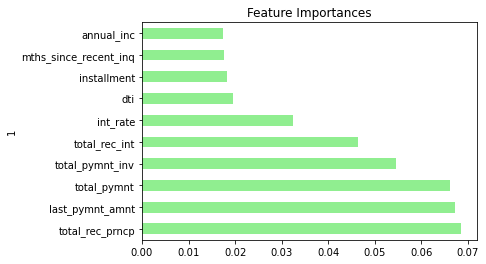

In [33]:
# Display The top 10 feature importances.
brf_importances_df[:10].plot(
    kind='barh',
    color='lightgreen',
    title = 'Feature Importances',
    legend = False
)

# The key feature the tree 

### Easy Ensemble Classifier

In [23]:
# Train the Classifier
from imblearn.ensemble import EasyEnsembleClassifier
ens = EasyEnsembleClassifier(n_estimators=100, random_state=1)
ens.fit(X_train_scaled, y_train)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [24]:
# Predictions on Easy Ensemble Classifier
y_pred_ens = ens.predict(X_test_scaled)

In [25]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred_ens)

0.7393285341162741

In [40]:
# Display the confusion matrix
cm2 = confusion_matrix(y_test, y_pred_ens)
cm2_df = pd.DataFrame(
    cm2,
    index = ['Actual High-risk', 'Actual Low-risk'],
    columns = ['Predicted High-risk', 'Predicted Low-risk']   
)
cm2_df

,Predicted High-risk,Predicted Low-risk
Actual High-risk,72,29
Actual Low-risk,4006,13098


In [27]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_ens))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.71      0.77      0.03      0.74      0.54       101
   low_risk       1.00      0.77      0.71      0.87      0.74      0.55     17104

avg / total       0.99      0.77      0.71      0.86      0.74      0.55     17205



CODER'S NOTE: Here we see more False Negatives. More low-risk loans were classified as high-risk. However, less high-risk loans were misclassified. So this model improved in capturing high-risk loans correctly. But with the imbalanced data heavily in favor of low-risk loans, we lost recall, but our True precision increased in capturing more low-risk loans. Overall, a better model than the balanced random forest. 

### Final Questions

**1. Which model had the best balanced accuracy score?**

The Easy Ensemble Classifer with a score of **74%** over the Balanced Random Forest score of **70%**.

**2. Which model had the best recall score?**

The Balanced Random Forest had a better recall at **81%** while the Ensemble Classifer was **77%** in capturing True Positives. 

**3. Which model had the best geometric mean score?**

    YOUR ANSWER HERE.

**4. What are the top three features?**

The Balanced Random Forest focused on 1) the principal of the loan, 2) the last payment amount, and 3) total payment of the last payment amount.
Ensemble Classifier doesn't support a feature importance function to 